In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import pdb
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from patch_geo_func import x_ep, y_ep, e_x
from sys import stdout
import warnings
import sobol_seq as ss
np.seterr(invalid = 'raise', under = 'ignore', over = 'ignore')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [3]:
from assign_attr import *
from repel_system import *
def nonFixedTrainingPoints(n, ecc):
    point = np.zeros((2,n))
    skip = 0
    i = 0
    rlim = [0, ecc]
    tlim = [-pi/2, pi/2]
    while i < n-1:
        ntmp = n-i;
        rands = ss.i4_sobol_generate(3, ntmp, skip=skip) 
        # add noise to avoid complete overlap
        rands = rands * (1 + np.random.normal(0, 0.01, (ntmp,3)))
        pt = tlim[0] + (tlim[1]-tlim[0]) * rands[:,0]
        pr = rlim[0] + (rlim[1]-rlim[0]) * rands[:,1]
        pick = np.logical_and(np.logical_and(pt < tlim[1], pt > tlim[0]), np.logical_and(pr < rlim[1], pr > rlim[0]))
        nselect = sum(pick)
        point[0, i:i+nselect] = pt[pick]
        point[1, i:i+nselect] = pr[pick]
        i += nselect
        skip += nselect
    return point

generate training points with temporal median and boundary fixed


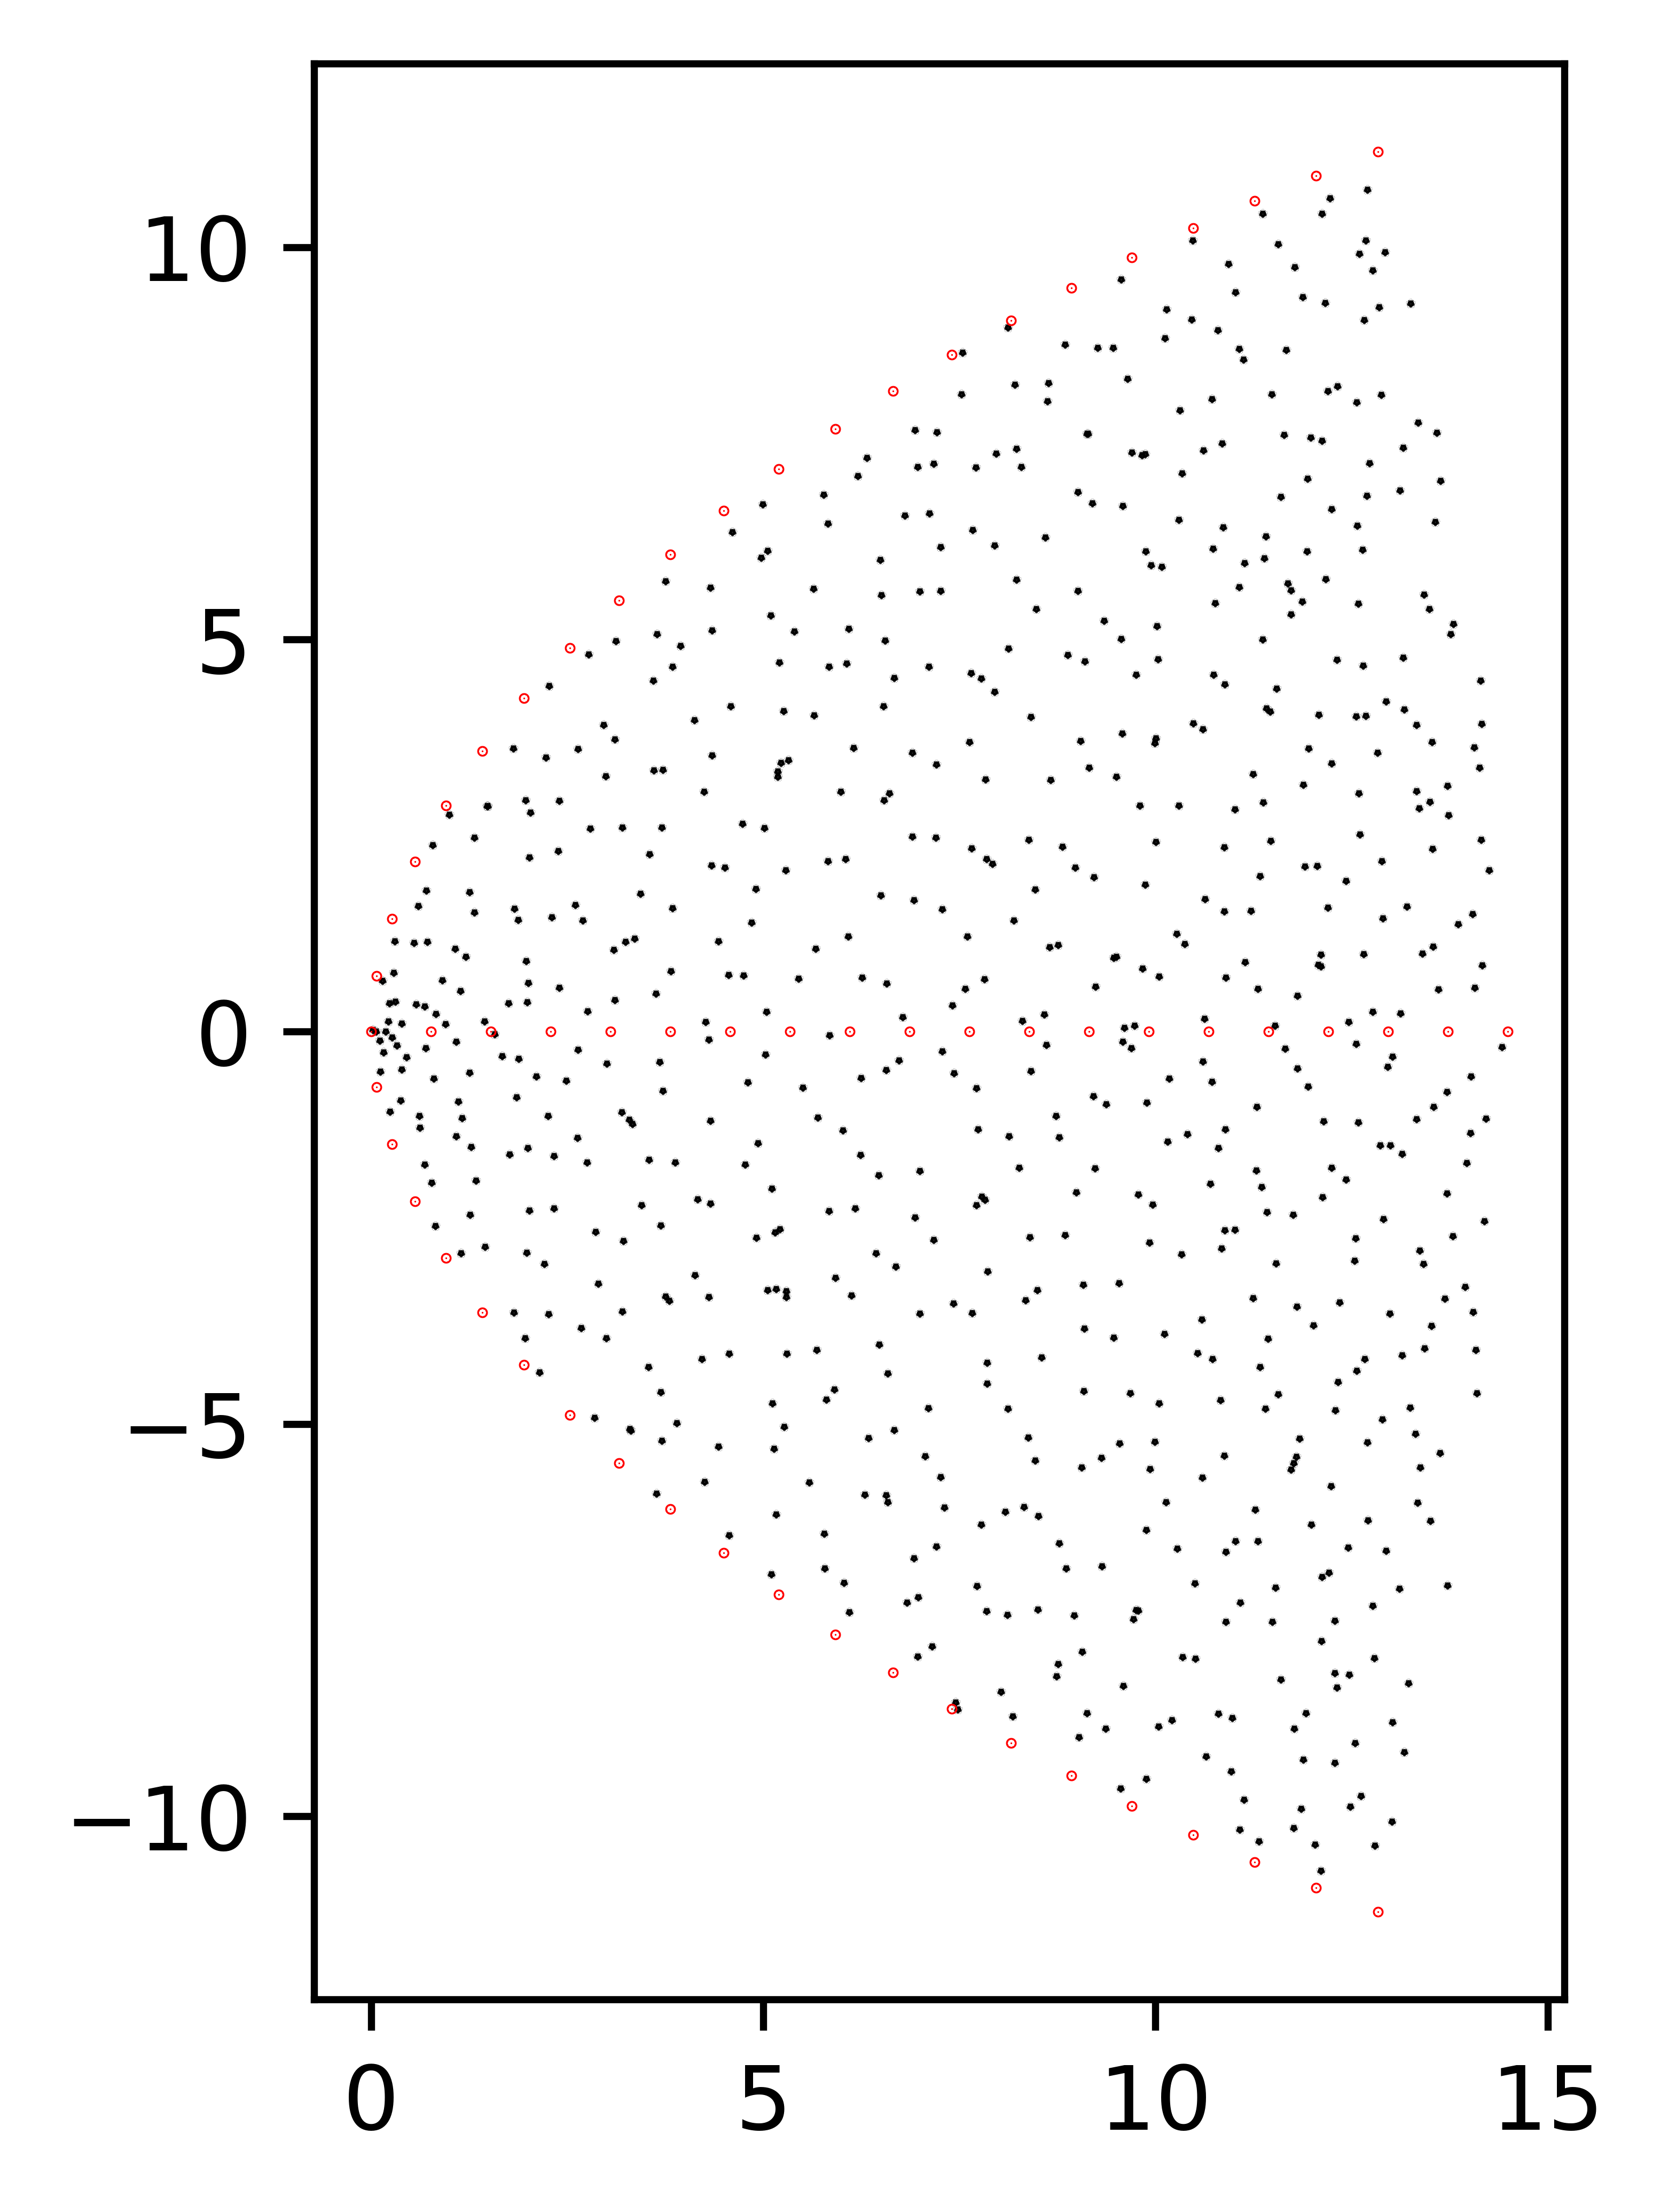

In [10]:
theme = 'hb-2.8'
b_scale = 2.8
output_file = 'Tmat_cortex-'+ theme + '.bin'
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
ecc = 2.0 # must consistent with the corresponding variables in parameter.m and macro.ipynb

grid = np.array([64,104])*2
nx = grid[0]
ny = grid[1]
W = x_ep(ecc,0,k,a,b)
x = np.linspace(-W/(2*nx-4), W+W/(2*nx-4), nx)
W = W+W/(nx-2)
d = W/(nx-1)
H = d*ny
y = np.linspace(-H/2, H/2, ny)

nTx = 20
nTy = 40
assert(np.mod(nTy,2) == 0)
trainSize = nTx*nTy
fixBound = True
pos = np.zeros((1,3,trainSize))
nyBound = 42
if fixBound:
    print('generate training points with temporal median and boundary fixed')
    n = nTx * nTy - nTx - nyBound
    pol_point = nonFixedTrainingPoints(n, ecc)
    for i in range(n):
        pos[0,0,i] = x_ep(pol_point[1,i],pol_point[0,i],k,a,b)
        pos[0,1,i] = y_ep(pol_point[1,i],pol_point[0,i],k,a,b)

    xmax = x_ep(ecc,0,k,a,b)
    xecc = np.linspace(0,xmax,nTx)
    pos[0,0,n:n+nTx] = xecc
    pos[0,1,n:n+nTx] = 0

    xecc_b = np.linspace(0,xmax,nyBound//2+1)
    ecc_b = e_x(xecc_b,k,a,b)
    bound = np.zeros((2,nyBound))
    #top
    bound[0,:nyBound//2] = [x_ep(e, pi/2, k, a, b) for e in ecc_b[1:]]
    bound[1,:nyBound//2] = [y_ep(e, pi/2, k, a, b) for e in ecc_b[1:]]
    #bot
    bound[0,nyBound//2:] = [x_ep(e, -pi/2, k, a, b) for e in ecc_b[1:]]
    bound[1,nyBound//2:] = [y_ep(e, -pi/2, k, a, b) for e in ecc_b[1:]]

    pos[0,0,n+nTx:] = bound[0,:]
    pos[0,1,n+nTx:] = bound[1,:]
else:
    print('generate training points with temporal median line fixed')
    n = nTx * nTy- nTx
    pol_point = nonFixedTrainingPoints(n, ecc)
    for i in range(n):
        pos[0,0,i] = x_ep(pol_point[1,i],pol_point[0,i],k,a,b)
        pos[0,1,i] = y_ep(pol_point[1,i],pol_point[0,i],k,a,b)

    xmax = x_ep(ecc,0,k,a,b)
    # clear out boundary to be consistent with b_scale
    x_b = xmax/((nTx-1)/(b_scale/2.0)+2.0)
    xecc = np.linspace(x_b, xmax-x_b, nTx)
    pos[0,0,n:] = xecc
    pos[0,1,n:] = 0
        
fixed = np.arange(n, trainSize)

with open(output_file, 'wb') as f:
    pos.tofile(f)

fig = plt.figure('initial_points', dpi = 600)
ax = fig.add_subplot(111)
ax.plot(pos[0,0,:n], pos[0,1,:n],'*k', ms = 0.2)
ax.plot(pos[0,0,n:], pos[0,1,n:],'or', ms = 0.2)
ax.set_aspect('equal')


In [11]:
LR_Pi_file = 'Ny-2-LR_Pi.bin'
#nx = 128
#ny = 208
#with open('Ny-2-LR_Pi_new.bin','r') as f:
#    Pi = np.reshape(np.fromfile(f, 'i4', count = nx*ny),(ny,nx))
#    LR = np.reshape(np.fromfile(f, 'f8', count = nx*ny),(ny,nx))
#LR = np.empty((ny,nx), dtype = 'i4')
    
pos_file = output_file
OR_file = None
vpos_file = 'Tmat_VF.bin'
uniform_pos_file = 'uniform_' + pos_file

p0 = -np.pi/2
p1 = np.pi/2

#mMap = macroMap(nx, ny, x, y, 1, trainSize, LR_Pi_file, 'uniform_' + pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = True, OD_file = OD_file, VF_file = vpos_file)
#mMap = macroMap(nx, ny, x, y, 1, trainSize, LR_Pi_file, 'uniform_' + pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = True)
mMap = macroMap(nx, ny, x, y, 1, trainSize, LR_Pi_file, pos_file, a, b, k, ecc, p0, p1, posUniform = False)
#mMap = macroMap(nx, ny, x, y, 1, trainSize, LR_Pi_file, pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = False, OD_file = OD_file)
if mMap.pODready:
    assert(np.sum(mMap.ODlabel>0) + np.sum(mMap.ODlabel<0) == mMap.trainSize)

209x339, ecc-polar grid houses 800 neurons
require 0.006 GB


In [12]:
min(x), max(x), min(y), max(y), min(pos[0,0,:]), max(pos[0,0,:]), min(pos[0,1,:]), max(pos[0,1,:])

(-0.0574997158394221,
 14.547428107373792,
 -11.959940894599798,
 11.959940894599798,
 0.0,
 14.48992839153437,
 -11.216868043807333,
 11.216868043807333)

In [13]:
fig = plt.figure('macroMap',dpi=1000)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(224, projection='polar')
#mMap.pODready = False
mMap.plot_map(ax1, ax2, ax3, fig.dpi, pltOD = True, pltVF = False, pltOP = False)

ax1.set_aspect('equal')
ax2.set_thetamin(p0/np.pi*180)
ax2.set_thetamax(p1/np.pi*180)
ax2.set_rmax(2.0)
ax2.set_rmin(0.0)
ax2.grid(False)
ax2.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)

ax3.set_thetamin(p0/np.pi*180)
ax3.set_thetamax(p1/np.pi*180)
ax3.set_rmax(2.0)
ax3.set_rmin(0.0)
ax3.grid(False)
ax3.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)
mMap.save(OD_file = 'T_od-'+theme+'.bin')

get the index of the nearest vertex for each neuron in its own grid
calculate neurons' cortical distance to the nearest vertex in the grid
0
adjust neuron positions near the boundary
#boundary points: 52 
assign ocular dominance preference to neuron according to their position in the cortex
retract neurons from the OD-boundary to avoid extreme repelling force later
get the index of the nearest vertex for each neuron in its own grid
calculate neurons' cortical distance to the nearest vertex in the grid


grid area: 216.87252311611488, used in simulation
defining the boundary midway through the grid
0.0057220458984375
characteristic length (inter-particle-distance)
particle:
a = 0.5594895209048205
b = 0.5594895209048205
k1 = 2
k2 = 1
cl = 0.5594895209048205
boundary:
a = 0.7832853292667487
b = 0.7832853292667487
k1 = 2
k2 = 1
cl = 0.7832853292667487
640 boundary points and 800 particles initialized
in units of grids (0.115,0.116):
    interparticle distance (2.433,2.421)
    radius of influence for particles (9.730,9.684)
    radius of influence for boundaries (13.622,13.557)
    default limiting of displacement in one dt: (2.433, 2.421)
initialized
100.000%, 44 particles' displacement are limited, 0 particles freezed

get the index of the nearest vertex for each neuron in its own grid
calculate neurons' cortical distance to the nearest vertex in the grid


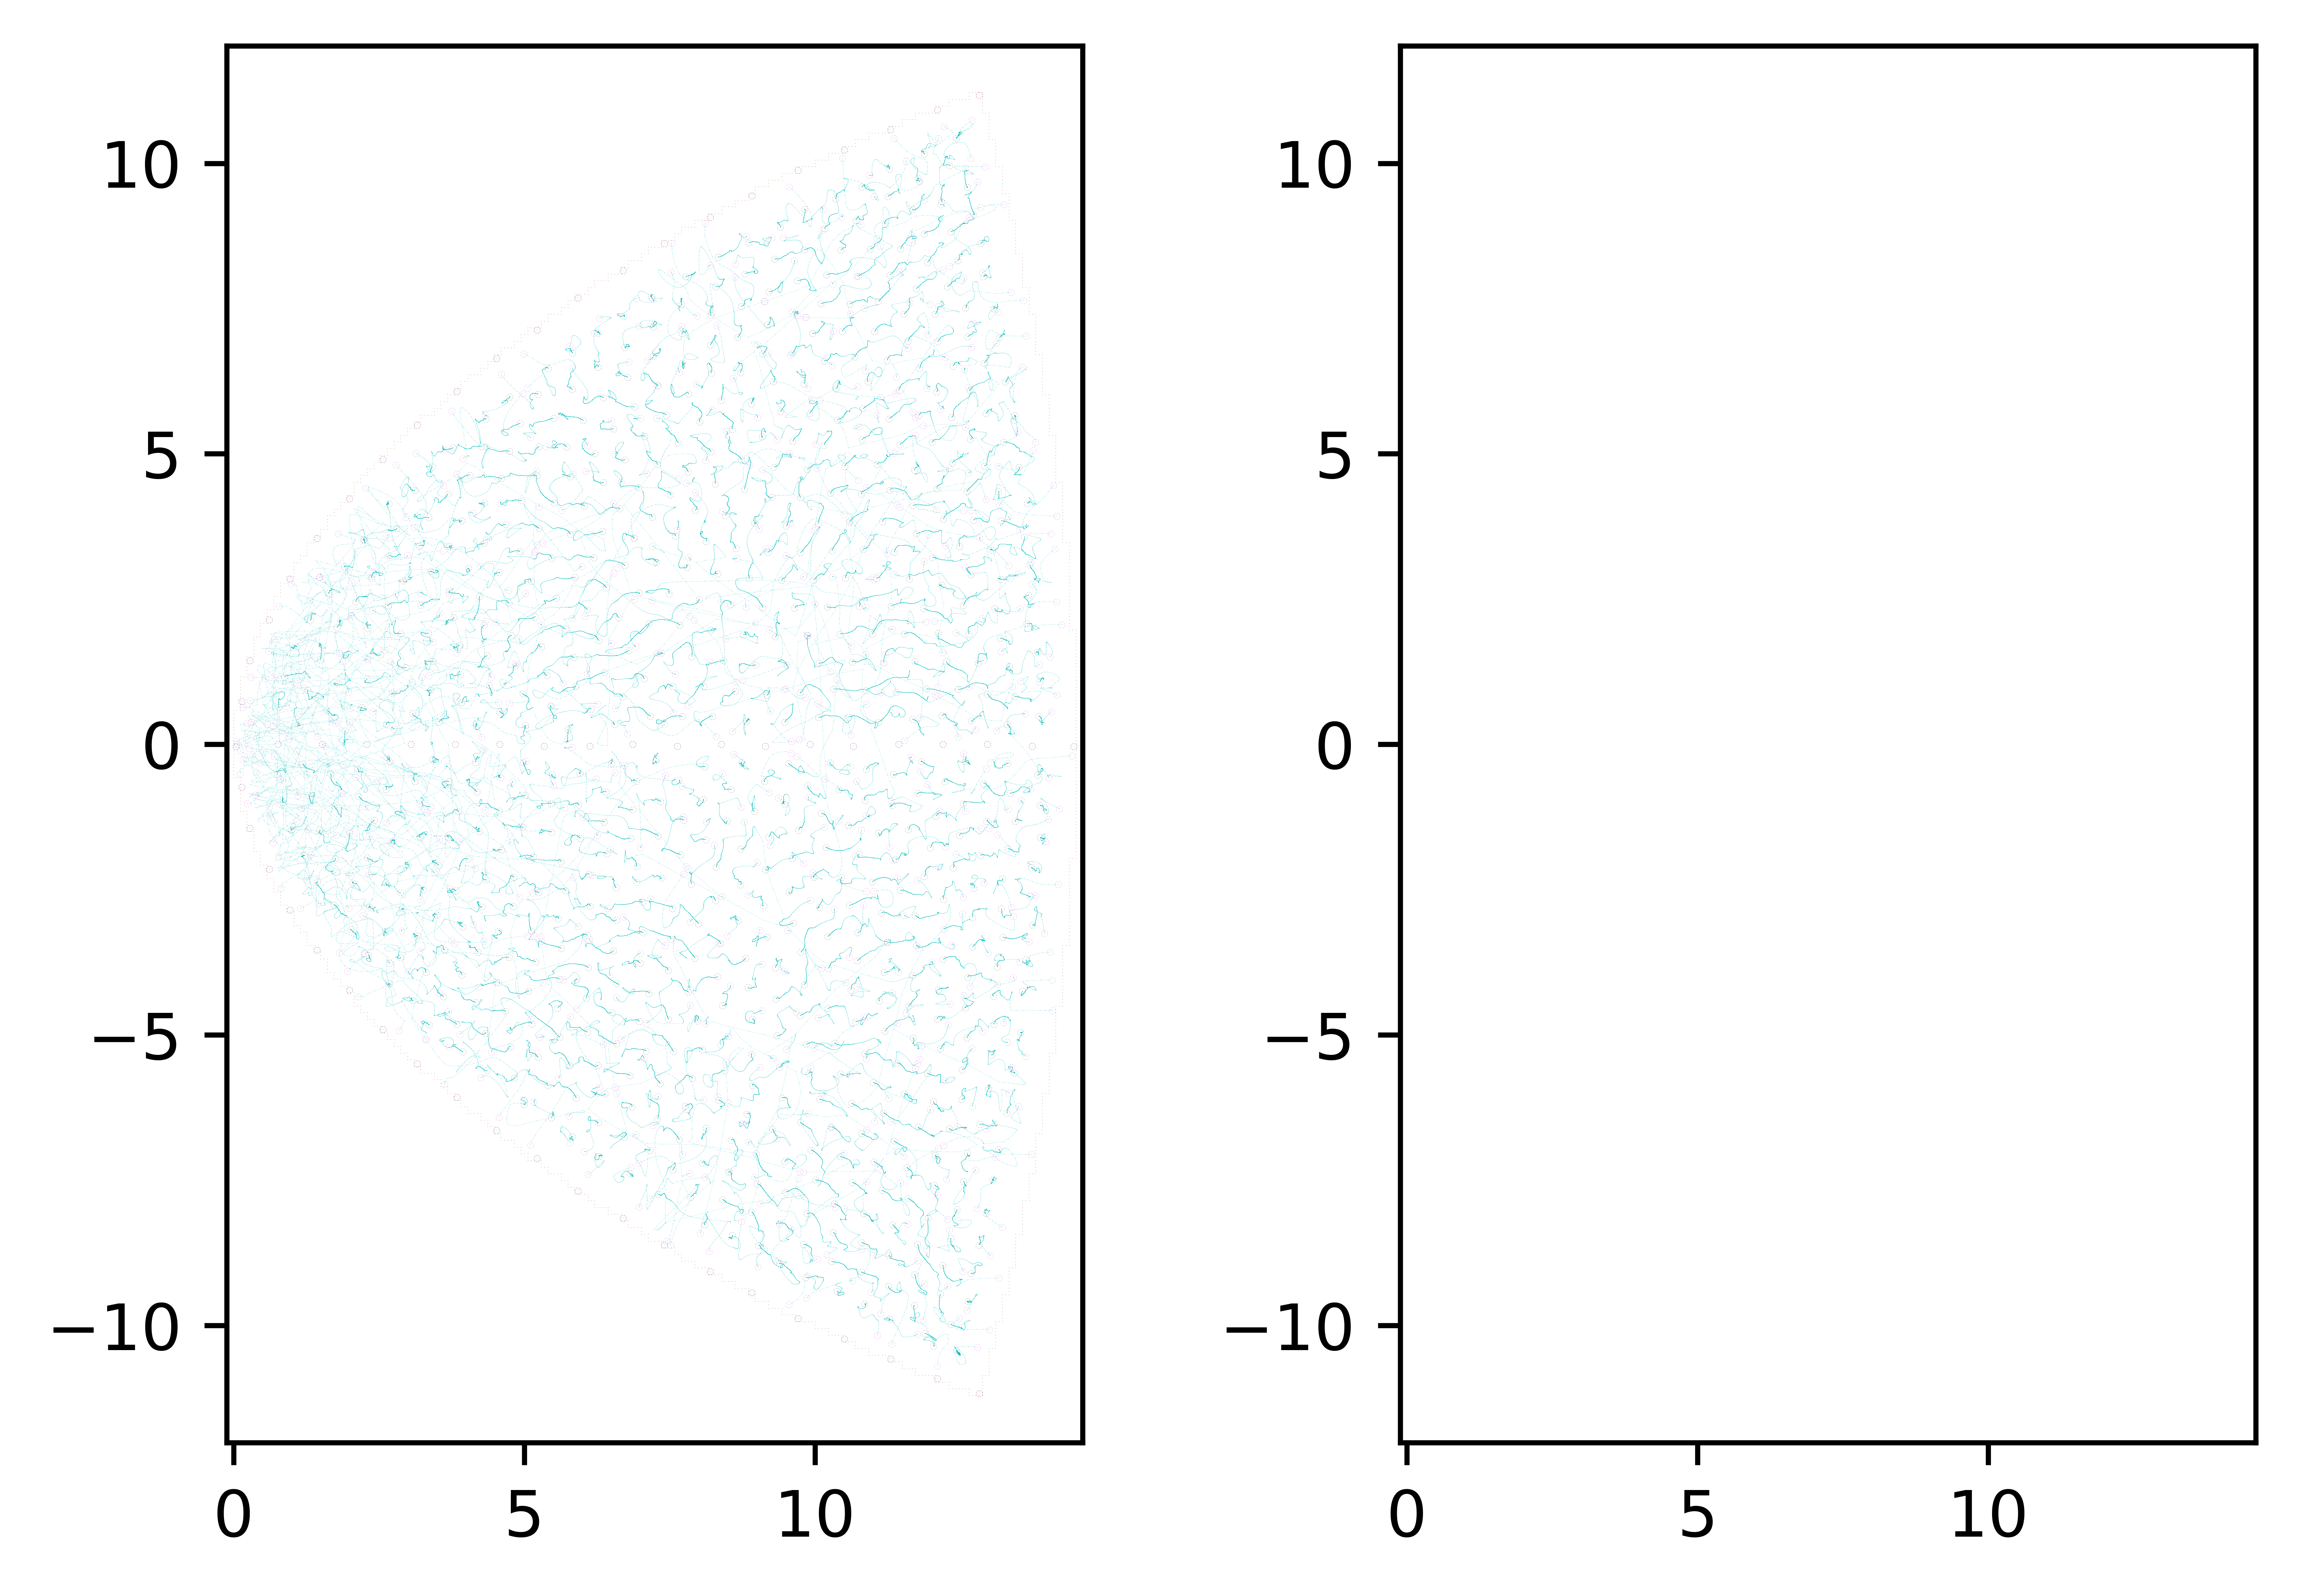

In [14]:
# spread uniformly
fig = plt.figure('pos', dpi = 600)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(121)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
ax2.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax2.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax2.set_aspect('equal')
dt0 = np.power(2.0,-np.arange(5,6)).reshape(1,1)
dt1 = np.power(2.0,-np.arange(6,7)).reshape(1,1)
dt = np.hstack((np.tile(dt0,(300,1)).flatten(), np.tile(dt1,(1,1)).flatten()))
#dt = np.tile(dt0,(15,1))
mMap.make_pos_uniformT(dt, seed = 17482321, ax1 = ax1, ax2 = ax2, b_scale = b_scale, fixed = fixed)
fig.savefig(pos_file+'-'+theme+'.png', dpi = 2000)

In [15]:
Training_pos = 'Training_pos-'+theme+'.bin'
mMap.vpos = mMap.assign_pos_VF(True)
ymax = y_ep(ecc,pi/2,k,a,b)
with open(Training_pos, 'wb') as f:
    np.array([mMap.networkSize]).tofile(f)
    mMap.pos.tofile(f)
    np.array([0,xmax]).tofile(f)
    np.array([-ymax,ymax]).tofile(f)
    mMap.vpos.tofile(f)

assgining visual field: 100.000%
